# This is an implementation of DDPG Algorithm

### Replay buffer

In [1]:
from collections import deque
import random
import numpy as np
 
class ReplayBuffer(object):
 
    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)
 
    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)
 
    def size(self):
        return self.count
 
    def sample_batch(self, batch_size):
        batch = []
 
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)
 
        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        #r_batch = np.array([_[2] for _ in batch])
        r_batch = [_[2] for _ in batch]
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])
 
        return s_batch, a_batch, r_batch, t_batch, s2_batch
 
    def clear(self):
        self.deque.clear()
        self.count = 0

### Activation functions

In [2]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    x[x<0.0] = 0.0
    return x

def deriv_sig(x):
    return (x)*(1-(x))

# giving the output of neuron here a = tanh(z), so we give belowe function "a"
def deriv_tanh(x):
    return (1.0 - (np.square(x)))

def deriv_relu(x):
    x[x>0.0] = 1.0
    return x

def linear(x):
    return x

def der_linear(x):
    return 1.0

### Create Actor Network

In [3]:
class actor_network(object):
    
    def __init__(self, s_dim, a_dim, a_bound, h_act=relu, hid_der_act=deriv_relu, 
                 op_act= tanh, op_der_act=deriv_tanh):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.a_bound = a_bound
        
        self.h_act = h_act
        self.hid_der_act = hid_der_act
        self.op_act = op_act
        self.op_der_act = op_der_act
        
        self.W1 = np.random.uniform(low=-np.sqrt(6.0/(self.s_dim+400)), 
                                    high=np.sqrt(6.0/(self.s_dim+400)), size=(self.s_dim,400))
        self.b1 = np.zeros(shape=(1,400))
        
        self.W2 = np.random.uniform(low=-np.sqrt(6.0/(400+300)), 
                                    high=np.sqrt(6.0/(400+300)), size=(400,300))
        self.b2 = np.zeros(shape=(1,300))
        
        self.W3 = np.random.uniform(low=-np.sqrt(6.0/(300+self.a_dim)), 
                                    high=np.sqrt(6.0/(300+self.a_dim)), size=(300,self.a_dim))
        self.b3 = np.zeros(shape=(1,self.a_dim))
        
        self.reg = 0.0
        self.tau = 0.001
        self.alpha = 0.0001
    
    def initialize(self, actor_instance):
        
        self.W1 = actor_instance.W1
        self.b1 = actor_instance.b1
        
        self.W2 = actor_instance.W2
        self.b2 = actor_instance.b2
        
        self.W3 = actor_instance.W3
        self.b3 = actor_instance.b3
        
        return None
    
    
    def predict_action(self,x_in):
        
        hh = np.dot(x_in, self.W1) + self.b1
        self.h1 = self.h_act(hh)
        self.h2 = self.h_act(np.dot(self.h1, self.W2) + self.b2) 
        self.h3 = self.op_act(np.dot(self.h2, self.W3) + self.b3)
        self.op = np.multiply(self.h3,self.a_bound)
        
        return self.op
    
    def update_network(self, x_batch, critic_instance, next_target):
        
        _action = self.predict_action(x_batch)
        
        dq_da = critic_instance.dQ_dA(x_batch, _action) #example dQ_da size 64 x 1 matrix
        delta3 = dq_da*self.a_bound*self.op_der_act(self.h3)  # 64 x 1        
        dW3 = np.dot(self.h2.T, delta3)  # self.h3 size 64 x 300 ==> 300 x 64 x 64 x 1 ==> 300 x 1
        db3 = np.sum(delta3, axis=0) # 64 x 1 is summed into 1x1
        
        delta2 = np.dot(delta3, self.W3.T)*self.hid_der_act(self.h2) # 64x1 x 1x300 ==> 64x300
        dW2 = np.dot(self.h1.T, delta2) # 400x64 x 64x300 ==> 400x300
        db2 = np.sum(delta2, axis=0) # summed into 1x300
        
        delta1 = np.dot(delta2, self.W2.T)*self.hid_der_act(self.h1) # 64x300 x (300x400) ==> 64 x 400
        dW1 = np.dot(x_batch.T, delta1) # 3x64 x 64x400 ==> 3x400
        db1 = np.sum(delta1, axis=0) #summed into 1x400
        
        #here we update the policy such that we can get maximum Q. So we do gradient ascent update 
        self.W3 = self.W3 + (self.alpha*(dW3 + (self.reg)*self.W3))
        self.b3 = self.b3 + (self.alpha*(db3 + (self.reg)*self.b3))
        self.W2 = self.W2 + (self.alpha*(dW2 + (self.reg)*self.W2))
        self.b2 = self.b2 + (self.alpha*(db2 + (self.reg)*self.b2))
        self.W1 = self.W1 + (self.alpha*(dW1 + (self.reg)*self.W1))
        self.b1 = self.b1 + (self.alpha*(db1 + (self.reg)*self.b1))
        
        return dq_da
    
    def update_target(self, actor_instance):
        
        self.W1 = (self.tau*actor_instance.W1) + ((1- self.tau)*self.W1)
        self.b1 = (self.tau*actor_instance.b1) + ((1- self.tau)*self.b1)
        self.W2 = (self.tau*actor_instance.W2) + ((1- self.tau)*self.W2)
        self.b2 = (self.tau*actor_instance.b2) + ((1- self.tau)*self.b2)
        self.W3 = (self.tau*actor_instance.W3) + ((1- self.tau)*self.W3)
        self.b3 = (self.tau*actor_instance.b3) + ((1- self.tau)*self.b3)
        
        

### Create Critic network

In [4]:
class critic_network(object):
    
    def __init__(self, s_dim, a_dim, a_bound, h_act = relu, hid_der_act = deriv_relu, 
                 op_act = linear):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.a_bound = a_bound        
        
        self.h_act = h_act
        self.hid_der_act = hid_der_act
        self.op_act = op_act
        
        self.reg = 0.0
        self.tau = 0.001
        self.alpha = 0.001
        
        self.W1 = np.random.uniform(low=-np.sqrt(6.0/(self.s_dim+400)), 
                                    high=np.sqrt(6.0/(self.s_dim+400)), 
                                    size=(self.s_dim,400))
        self.b1 = np.zeros(shape=(1,400))
        
        self.W2 = np.random.uniform(low=-np.sqrt(6.0/(400+300)), 
                                    high=np.sqrt(6.0/(400+300)), size=(400,300))
        self.W2_2 = np.random.uniform(low=-np.sqrt(6.0/(self.a_dim+300)), 
                                    high=np.sqrt(6.0/(self.a_dim+300)), 
                                      size=(self.a_dim,300))
        self.b2 = np.zeros(shape=(1,300))
        
        self.W3 = np.random.uniform(low=-np.sqrt(6.0/(300+self.a_dim)), 
                                    high=np.sqrt(6.0/(300+self.a_dim)), 
                                    size=(300, self.a_dim))
        self.b3 = np.zeros(shape=(1,a_dim))
        
        self.a_bound = a_bound
        
    def initialize(self, critic_instance):
        
        self.W1 = critic_instance.W1
        self.b1 = critic_instance.b1
        
        self.W2 = critic_instance.W2
        
        self.W2_2 = critic_instance.W2_2
        self.b2 = critic_instance.b2
                                      
        self.W3 = critic_instance.W3
        self.b3 = critic_instance.b3
        
        return None
        
    def forward(self, x_in, action_in):
        
        self.h1 = self.h_act(np.dot(x_in,self.W1) + self.b1)
        
        self.z2 = np.dot(self.h1, self.W2)
        self.z2_2 = np.dot(action_in, self.W2_2)
        self.h2 = self.h_act(self.z2 + self.z2_2 + self.b2)
        
        self.h3 = self.op_act(np.dot(self.h2, self.W3) + self.b3) # linear output
        
        return self.h3
    
    def update(self, x_in, action_in, Q_target):
        
        Q_critic_op = self.forward(x_in, action_in)
        
        loss = (1./(2*x_in.shape[0]))*np.sum((Q_critic_op - Q_target)**2)
        
        delta3 = (1./x_in.shape[0])*(Q_critic_op - Q_target)
        
        dW3 = np.dot(self.h2.T, delta3)
        db3 = np.sum(delta3, axis=0)
        
        delta2 = np.dot(delta3, self.W3.T)*self.hid_der_act(self.h2)
        dW2 = np.dot(self.h1.T, delta2)
        dW2_2 = np.dot(action_in.T, delta2) ## -dQ/da
        db2 = np.sum(delta2, axis=0)
        
        dl_da = np.dot(delta2, self.W2_2.T)
        
        delta1 = np.dot(delta2, self.W2.T)*self.hid_der_act(self.h1)
        dW1 = np.dot(x_in.T, delta1)
        db1 = np.sum(delta1, axis=0)
        
        # mean squared error loss between target and predicted Q(s,a) values
        self.W3 = self.W3 - self.alpha*(dW3)
        self.b3 = self.b3 - self.alpha*(db3)
        self.W2 = self.W2 - self.alpha*(dW2)
        self.W2_2 = self.W2_2 - self.alpha*(dW2_2)
        self.b2 = self.b2 - self.alpha*(db2)
        self.W1 = self.W1 - self.alpha*(dW1)
        self.b1 = self.b1 - self.alpha*(db1)
        '''reg_loss = (self.reg/x_in.shape[0])*(np.sum(np.square(self.W1))+
                                          np.sum(np.square(self.W2))+
                                          np.sum(np.square(self.W2_2))+
                                          np.sum(np.square(self.W3)))
        '''
        total_loss = loss 
        
        #return total_loss, Q_policy_critic, grad_W3, grad_b3
        return dl_da
        
    def dQ_dA(self, x_in, action_in):
        
        Q = self.forward(x_in, action_in)
        #print('Q values of critic for actor update', Q)
        delta3 = np.ones(shape=(x_in.shape[0],1))
        delta2 = np.dot(delta3, self.W3.T)*self.hid_der_act(self.h2) # W3 = (300 x 1) , delta3 = (64 x 1) ==> 64 x 300 
        #print('delta2', delta2)
        dq_da = np.dot(delta2, self.W2_2.T) # W2_2 = (action_size, 300)  ==> (64 x 300) x (300 x act_size) ==> 64 x act_size
        
        return dq_da
        
    def update_target(self, critic_instance):
        
        self.W1 = (self.tau*critic_instance.W1) + ((1- self.tau)*self.W1)
        self.b1 = (self.tau*critic_instance.b1) + ((1- self.tau)*self.b1)
        self.W2 = (self.tau*critic_instance.W2) + ((1- self.tau)*self.W2)
        self.W2_2 = (self.tau*critic_instance.W2_2) + ((1- self.tau)*self.W2_2)
        self.b2 = (self.tau*critic_instance.b2) + ((1- self.tau)*self.b2)
        self.W3 = (self.tau*critic_instance.W3) + ((1- self.tau)*self.W3)
        self.b3 = (self.tau*critic_instance.b3) + ((1- self.tau)*self.b3)
        
        return None
    

### OU noise class

In [5]:
class OU_noise(object):
    """ 
    https://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
    OU Noise implemented from the above link.
    
    The stochastic differential equation (SDE) 
        dxt = θ*(μ−xt)*dt + σ*dWt
    can be discretized and approximated via
        Xn+1 = Xn + θ*(μ−Xn)*Δt + σ* ΔWn
    where ΔWn are independent identically distributed Wiener increments, 
    i.e., normal variates with zero mean and variance Δt. Thus, 
        Wtn+1−Wtn=ΔWn∼N(0,Δt)= √Δt*N(0,1)
    where N(0,1) is a normal distribution (Gaussian Distribution)
    #matlab code
    Ex: th = 1;
        mu = 1.2;
        sig = 0.3;
        dt = 1e-2;
        t = 0:dt:2;             % Time vector
        x = zeros(1,length(t)); % Allocate output vector, set initial condition
        rng(1);                 % Set random seed
        for i = 1:length(t)-1
            x(i+1) = x(i)+th*(mu-x(i))*dt+sig*sqrt(dt)*randn;
        end
        figure;
        plot(t,x);
    
    DDPG paper ornstein-uhlenbeck noise parameters are theta=0.15, sigma=0.2 
    
    """
    
    def __init__(self, env, theta = 0.1, sigma = 0.1, x0 = None):
        # x0 is action_space size
        self.mu = np.zeros(shape=(1,env.action_space.shape[0]))
        self.theta = theta
        self.sigma = sigma
        self.dt = 1e-2
        self.x0 = np.zeros(shape=(1,self.mu.shape[0])) if x0 is None else x0
        
    def sample(self):
        self.x0 = self.x0 + self.theta*(self.mu - self.x0)*self.dt + self.sigma*np.sqrt(self.dt)*np.random.normal(size=self.mu.shape)  
        return self.x0 

### Set the Environment for Reinforcement learning

In [6]:
import gym
ENV_NAME = 'Pendulum-v0'
RANDOM_SEED = 1234
# Size of replay buffer

env = gym.make(ENV_NAME)
np.random.seed(RANDOM_SEED)
env.seed(RANDOM_SEED)
state_dim = env.observation_space.shape[0] # 3
action_dim = env.action_space.shape[0] # 1
action_bound = env.action_space.high # 1-D array [2.0]
action_bound = action_bound[0]

BUFFER_SIZE = 200000
MINIBATCH_SIZE = 64

[2018-05-16 16:13:44,742] Making new env: Pendulum-v0


### Initialize the networks and replay buffer

In [7]:
actor = actor_network(s_dim=state_dim, a_dim=action_dim, a_bound=action_bound)
critic = critic_network(s_dim=state_dim, a_dim=action_dim, a_bound=action_bound)

target_actor = actor_network(s_dim=state_dim, a_dim=action_dim, a_bound=action_bound)
target_critic = critic_network(s_dim=state_dim, a_dim=action_dim, a_bound=action_bound)

target_actor.initialize(actor)
target_critic.initialize(critic)

replay_buffer = ReplayBuffer(BUFFER_SIZE, RANDOM_SEED)

### Train

In [8]:
num_episodes = 1000
time_steps = 200
x0 = np.zeros(shape=(1,env.action_space.shape[0]))
noise = OU_noise(env=env, x0=x0)
rALL = []
for i in range(num_episodes): 
    
    s = env.reset() #print(s.ndim, s.shape) 1 (3,)
    ep_reward = 0.0
    
    for j in range(time_steps):
        
        a = actor.predict_action(np.reshape(s, (1, 3))) + noise.sample() #reshape s into (1,3) sahpe
        a = a.clip(-action_bound, action_bound)
        #print('action',a[0], a.shape, type(a))
        s2, r, terminal, info = env.step(a[0])
 
        replay_buffer.add(np.reshape(s, (actor.s_dim,)), np.reshape(a, (actor.a_dim,)), r, \
                terminal, np.reshape(s2, (actor.s_dim,)))
 
        if replay_buffer.size() > MINIBATCH_SIZE:
            
            s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(MINIBATCH_SIZE)
            
            target_q = target_critic.forward(s2_batch, target_actor.predict_action(s2_batch))

            y_i = []
            for k in range(MINIBATCH_SIZE):
                if t_batch[k]:
                    y_i.append(np.asarray([r_batch[k]]))
                    
                else:
                    rr = (r_batch[k]) + (0.99*target_q[k])
                    y_i.append(rr)
           
            y_i = np.asarray(y_i).reshape(64,1)
        
            dl_da = critic.update(s_batch, a_batch, y_i )
            
            _ = actor.update_network(s_batch,critic, y_i)                
                
            # Update target networks
            target_actor.update_target(actor)
            target_critic.update_target(critic)
            #print('finished one update')
        s = s2
        ep_reward += r
 
        if terminal:
            print('episode',i, 'episode total reward ', ep_reward)
            rALL.append(ep_reward)
            #print('num of steps in the episode', j)
            '''if i%20 == 0:
                print('actor W1', actor.W1)
                print('critic W1', critic.W1)
                print('target actor W1', target_actor.W1)
                print('target critic W1', target_critic.W1)'''
            break

episode 0 episode total reward  -1312.7318765300215
episode 1 episode total reward  -1793.6197837037785
episode 2 episode total reward  -1253.416548726512
episode 3 episode total reward  -1496.8898031466908
episode 4 episode total reward  -1468.9404017810452
episode 5 episode total reward  -1535.465169418014
episode 6 episode total reward  -1578.2229103563197
episode 7 episode total reward  -1467.5257363007322
episode 8 episode total reward  -1336.7647707019744
episode 9 episode total reward  -1575.8996163554389
episode 10 episode total reward  -1647.8207537620256
episode 11 episode total reward  -1428.768006869623
episode 12 episode total reward  -1562.9619046273747
episode 13 episode total reward  -1468.6229926263156
episode 14 episode total reward  -1493.9273434223533
episode 15 episode total reward  -1505.3462215492768
episode 16 episode total reward  -1440.0379007356546
episode 17 episode total reward  -1360.263053787541
episode 18 episode total reward  -1481.2788254511415
episode

episode 155 episode total reward  -925.08147678102
episode 156 episode total reward  -1197.8696336151247
episode 157 episode total reward  -1434.7511270732452
episode 158 episode total reward  -1535.4951103958608
episode 159 episode total reward  -1528.8689594558175
episode 160 episode total reward  -1568.6494692611664
episode 161 episode total reward  -1185.3329664981616
episode 162 episode total reward  -1520.508669598854
episode 163 episode total reward  -1229.582113736454
episode 164 episode total reward  -1182.7810164764614
episode 165 episode total reward  -1154.9950901257553
episode 166 episode total reward  -1534.4598068119662
episode 167 episode total reward  -1562.222567692499
episode 168 episode total reward  -1628.499664908099
episode 169 episode total reward  -1135.1860126796237
episode 170 episode total reward  -1172.0182765757406
episode 171 episode total reward  -1016.5716320914327
episode 172 episode total reward  -1062.5264217733686
episode 173 episode total reward  -

episode 309 episode total reward  -126.57685576156248
episode 310 episode total reward  -124.89518831512565
episode 311 episode total reward  -125.85899948778683
episode 312 episode total reward  -126.39104202225208
episode 313 episode total reward  -251.17265151389876
episode 314 episode total reward  -122.93073571006956
episode 315 episode total reward  -341.7078554553482
episode 316 episode total reward  -248.17986359280326
episode 317 episode total reward  -238.50458093342587
episode 318 episode total reward  -246.92696248669444
episode 319 episode total reward  -124.94606857090102
episode 320 episode total reward  -122.57662460534732
episode 321 episode total reward  -125.21490241400483
episode 322 episode total reward  -1.6826650850693539
episode 323 episode total reward  -258.5970597361622
episode 324 episode total reward  -128.11017251575805
episode 325 episode total reward  -382.0532551072247
episode 326 episode total reward  -233.9443358869343
episode 327 episode total reward

episode 462 episode total reward  -117.05916627119049
episode 463 episode total reward  -243.32715303654157
episode 464 episode total reward  -121.26189403868516
episode 465 episode total reward  -126.70065692518736
episode 466 episode total reward  -240.88366569796418
episode 467 episode total reward  -3.7501076740225083
episode 468 episode total reward  -121.35204117005843
episode 469 episode total reward  -120.88784907677207
episode 470 episode total reward  -127.9760189202127
episode 471 episode total reward  -125.4162284908964
episode 472 episode total reward  -2.53808228007468
episode 473 episode total reward  -329.829312157068
episode 474 episode total reward  -241.67845427619443
episode 475 episode total reward  -3.0236327955771505
episode 476 episode total reward  -349.9733160645415
episode 477 episode total reward  -242.78346421939634
episode 478 episode total reward  -124.65477738715275
episode 479 episode total reward  -2.023770927690198
episode 480 episode total reward  -1

episode 615 episode total reward  -256.73166804905895
episode 616 episode total reward  -2.5644585517817493
episode 617 episode total reward  -124.20785214777037
episode 618 episode total reward  -230.2003417425651
episode 619 episode total reward  -128.6125167034391
episode 620 episode total reward  -118.58728017607824
episode 621 episode total reward  -125.5625388982301
episode 622 episode total reward  -123.0943552301767
episode 623 episode total reward  -243.21589917562136
episode 624 episode total reward  -1.9123355112242002
episode 625 episode total reward  -242.34140852722837
episode 626 episode total reward  -243.31553869262618
episode 627 episode total reward  -124.42843180536833
episode 628 episode total reward  -7.530330072109663
episode 629 episode total reward  -250.6424080786142
episode 630 episode total reward  -117.15586084462132
episode 631 episode total reward  -124.366548932987
episode 632 episode total reward  -126.8139663678671
episode 633 episode total reward  -12

episode 768 episode total reward  -2.759126794231212
episode 769 episode total reward  -124.17438767316092
episode 770 episode total reward  -118.29711730946497
episode 771 episode total reward  -249.8853985157216
episode 772 episode total reward  -118.70823596420377
episode 773 episode total reward  -126.74007021683536
episode 774 episode total reward  -128.96717612441705
episode 775 episode total reward  -121.78120200202879
episode 776 episode total reward  -124.189508687294
episode 777 episode total reward  -235.08001971753066
episode 778 episode total reward  -121.14153419314181
episode 779 episode total reward  -335.8325223670839
episode 780 episode total reward  -2.6110356901172302
episode 781 episode total reward  -5.467231197129161
episode 782 episode total reward  -119.7560469162773
episode 783 episode total reward  -126.79553007385931
episode 784 episode total reward  -228.2139572485894
episode 785 episode total reward  -125.04222125674127
episode 786 episode total reward  -2

episode 921 episode total reward  -122.98247392478044
episode 922 episode total reward  -119.97567525336481
episode 923 episode total reward  -3.11729761776322
episode 924 episode total reward  -3.30112642235715
episode 925 episode total reward  -232.72668474794145
episode 926 episode total reward  -124.71172393956917
episode 927 episode total reward  -256.2180587958124
episode 928 episode total reward  -120.32663008321195
episode 929 episode total reward  -116.42446750244746
episode 930 episode total reward  -248.35181839893218
episode 931 episode total reward  -126.23630921165109
episode 932 episode total reward  -121.5744421314084
episode 933 episode total reward  -246.81751897670546
episode 934 episode total reward  -250.27143838652754
episode 935 episode total reward  -270.67066233489936
episode 936 episode total reward  -4.145920927195325
episode 937 episode total reward  -126.41998192100597
episode 938 episode total reward  -124.39912404216595
episode 939 episode total reward  -

### Plot the training rewards in each epoch

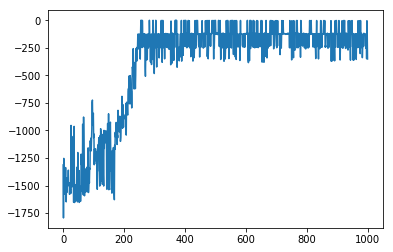

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(rALL)

### Testing

starting initial state [-0.97630722  0.21638903  0.62302659]
episode 0 episode total reward  -232.72049798448688
starting initial state [-0.40635898  0.91371351 -0.37051354]
episode 1 episode total reward  -124.8189091803233
starting initial state [ 0.7944018   0.60739261 -0.91037232]
episode 2 episode total reward  -134.1554008939265
starting initial state [ 0.70229523  0.71188581 -0.09892761]
episode 3 episode total reward  -129.01473723970628
starting initial state [-0.08215891 -0.99661924 -0.61709284]
episode 4 episode total reward  -120.20121362987534
starting initial state [-0.24599778  0.96927039 -0.72121839]
episode 5 episode total reward  -127.28507010892547
starting initial state [-0.62664111  0.77930798 -0.27202874]
episode 6 episode total reward  -250.06176222161787
starting initial state [ 0.20524593 -0.97871043  0.75470831]
episode 7 episode total reward  -125.74879862921432
starting initial state [ 0.7468991  -0.66493739 -0.37127611]
episode 8 episode total reward  -129.

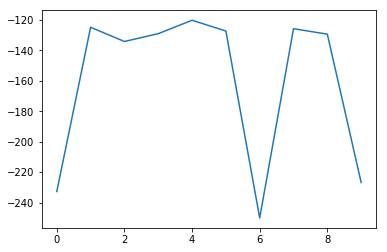

In [10]:
import time
test_episodes = 10
ep_reward_list = []
for i in range(test_episodes):
    s = env.reset() #print(s.ndim, s.shape) 1 (3,)
    print('starting initial state', s)
    ep_reward = 0.0
    #env.render()
    #time.sleep(5)
    for j in range(200):
        #env.render()
        # Added exploration noise
        #print("state", s)
        a = actor.predict_action(np.reshape(s, (1, state_dim))) 
        
        s2, r, terminal, info = env.step(a[0])
        s = s2
        ep_reward += r
        
        if terminal:
            print('episode',i, 'episode total reward ', ep_reward)
            ep_reward_list.append(ep_reward)
            break
            
plt.plot(ep_reward_list)